## INITIALIZATION

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
from bitarray import bitarray
from tjmonopix.tjmonopix import TJMonoPix
%matplotlib notebook

from tjmonopix.online_monitor import noise_monitor, plots

In [3]:
##### if HV is on, no_power_reset=True,
##### if GPAC had power reset then no_power_reset=False

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml",no_power_reset=False)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45

2022-02-02 15:09:29,098 [INFO ] (MainThread) GPAC: power reset
2022-02-02 15:09:30,803 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 3
2022-02-02 15:09:31,042 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2022-02-02 15:09:31,273 [INFO ] (MainThread) ibias = 45
2022-02-02 15:09:31,289 [INFO ] (MainThread) ibias = 503.125 nA
2022-02-02 15:09:31,844 [INFO ] (MainThread) {'VPC [V]': 1.2998506463536463, 'VDDA_DAC [mA]': 3.002966091804109, 'VDDP [V]': 1.8059798142570278, 'VDDP OC': False, 'VDDA [mA]': 49.13820989930726, 'VDDD [V]': 1.8015140363636364, 'VDDA_DAC OC': False, 'VDDD [mA]': 2.820288999038665e-08, 'VPCSWSF [V]': 0.5001542395802099, 'VDDP [mA]': 128.39714805315754, 'BiasSF [V]': 1.0537782852856015, 'VDDD OC': False, 'VPC [mA]': -0.060499728174391094, 'VPCSWSF [mA]': -0.039519603448544334, 'VDDA [V]': 1.8058565495495498, 'VDDA OC': False, 'VDDA_DAC [V]': 1.8035484515484517, 'BiasSF [mA]': 0.10109892318840588}


## POWER STATUS

In [4]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
power_status = chip.get_power_status(printen=True)

BiasSF [V] = 1.05827928763
BiasSF [mA] = 0.100594470965
VDDA OC = False
VDDA [V] = 1.80585654955
VDDA [mA] = 49.6447893826
VDDA_DAC OC = False
VDDA_DAC [V] = 1.80454723776
VDDA_DAC [mA] = 3.0029660918
VDDD OC = False
VDDD [V] = 1.80151403636
VDDD [mA] = 2.82028899904e-08
VDDP OC = False
VDDP [V] = 1.80697935141
VDDP [mA] = 127.893629826
VPC [V] = 1.29935158047
VPC [mA] = -0.327498551958
VPCSWSF [V] = 0.50015423958
VPCSWSF [mA] = 0.0625310336561


## COLUMN SETTINGS: FLAVOURS, MASKS, INJECTION

In [5]:
# SELECT WHICH DOUBLE COLUMNS (PIXEL "FLAVOURS") TO ENABLE
chip['CONF_SR']['EN_PMOS_NOSF'].setall(False)
chip['CONF_SR']['EN_PMOS'].setall(False)
chip['CONF_SR']['EN_COMP'].setall(False)
chip['CONF_SR']['EN_HV'].setall(True)
chip['CONF_SR']['EN_OUT'].setall(False) #ENABLES OR DISABLES THE NORMAL OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['nEN_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY OUTPUT PADS, ACTIVE LOW
chip['CONF_SR']['EN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE NORMAL HITOR PADS, HITOR0-3 =  1-4 flavor, ACTIVE LOW
chip['CONF_SR']['nEN_HITOR_OUT'].setall(True) #ENABLES OR DISABLES THE COMPLEMENTARY HITOR PADS, ACTIVE LOW

chip.write_conf()

In [6]:
# SELECT WHICH PHYSICAL COLUMNS, ROWS, DIAGONALS TO MASK
# TO MASK ONE PIXEL, MASKV, MASKH and MASKD OF THIS PIXEL SHOULD BE 0 (FALSE)
# THE MASKD NUMBER OF THE PIXEL WE WANT TO MASK (or UNMASK), IS GIVEN BY: MASKD = PHYSCOL- PHYSROW
# IF PHYSCOL-PHYSROW<0, then MASKD = 448+PHYSCOL-PHYSROW
chip['CONF_SR']['MASKD'].setall(True)
chip['CONF_SR']['MASKH'].setall(True)
chip['CONF_SR']['MASKV'].setall(True)

# TO USE THE MASK FUNCTION YOU MUST INPUT THE FLAVOR, COLUMN AND ROW
# THE FLAVOR NUMERS IS: 0 FOR PMOS_NOSF, 1 FOR PMOS, 2 FOR COMP, 3 FOR HV

chip.write_conf()

In [7]:
# SELECT WHICH PHYSICAL COLUMS TO INJECT
# INJ_IN_MON_L AND INJ_IN_MON_L SELECT THE LEFT AND RIGHT SPECIAL ANALOG MONITORING PIXELS
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)

chip['CONF_SR']['INJ_IN_MON_L'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS LEFT SIDE
chip['CONF_SR']['INJ_IN_MON_R'] = 1 # ENABLE INJECTION FOR THE ANALOG MONITORING PIXELS RIGHT SIDE

# SELECT WHICH PHYSICAL ROWS TO INJECT
# THE SPEXIAL PIXELS OUTA_MON3 to OUTA_MON0 CORRESPONT TO ROWS 223 to 220 FOR INJECTION
chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['INJ_ROW'][223:220] = True # FOR THE ANALOG MONITORING TOP PIXEL

# SELECT PHYSICAL COLUMNS AND ROWS FOR INJECTION WITH FUNCTION
#chip.enable_injection(3,18,99)

chip.write_conf()

In [8]:
# SELECT PHYSICAL COLUMN(S) FOR HITOR OUTPUT
# nMASKH (SO SETTING MASKH TO FALSE) ENABLES HITOR FOR THE SPECIFIC ROW
chip['CONF_SR']['DIG_MON_SEL'].setall(False)
#chip.enable_column_hitor(1,18)

chip.write_conf()

## ANALOG FRONT END CONFIGURATION

In [9]:
vl_dac = 40
vh_dac = 80
vreset_dac = 35
icasn_dac = 0  # This sets the baseline voltage of the discriminator input
ireset_dac = 2
ithr_dac = 5  # Also this sets the baseline voltage of the discriminator input
idb_dac = 50  # This sets the threshold of the discriminator
ibias_dac = 100


## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# Cinj=230aF => 1.43e-/mV
# VDAC LSB=14.17mV => 20.3e-/LSB
# The default values are VL=44, VH=79, VH-VL=35 => ~710e-
CALCAP=33 ## 33 or 14.17E-3*230E-18/1.602E-19=20.3
vl = chip.set_vl_dacunits(vl_dac,1)
vh = chip.set_vh_dacunits(vh_dac,1)

chip.write_conf()

2022-02-02 15:10:41,943 [INFO ] (MainThread) vl = 0.951929133858V
2022-02-02 15:10:41,957 [INFO ] (MainThread) vh = 1.51885826772V


In [10]:
# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
vreset = chip.set_vreset_dacunits(vreset_dac, 1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
icasn = chip.set_icasn_dacunits(icasn_dac,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
ireset = chip.set_ireset_dacunits(ireset_dac,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
ithr = chip.set_ithr_dacunits(ithr_dac,1) #680pA ## default=5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
idb = chip.set_idb_dacunits(idb_dac,1) #500nA  

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
ibias = chip.set_ibias_dacunits(ibias_dac,1) #500nA default=50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()


setted_param_dac = np.array([vl_dac, vh_dac, vreset_dac, icasn_dac, ireset_dac, ithr_dac, idb_dac, ibias_dac])
setted_param = np.array([vl, vh, vreset, icasn, ireset, ithr, idb, ibias])

2022-02-02 15:10:44,617 [INFO ] (MainThread) vreset = 1.05106299213V
2022-02-02 15:10:44,631 [INFO ] (MainThread) icasn = 0
2022-02-02 15:10:44,648 [INFO ] (MainThread) icasn = 4.375 nA
2022-02-02 15:10:44,664 [INFO ] (MainThread) ireset = 2 high leakage mode
2022-02-02 15:10:44,678 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2022-02-02 15:10:44,700 [INFO ] (MainThread) ithr = 5
2022-02-02 15:10:44,717 [INFO ] (MainThread) ithr = 0.8203125 nA
2022-02-02 15:10:44,733 [INFO ] (MainThread) idb = 50
2022-02-02 15:10:44,747 [INFO ] (MainThread) idb = 892.5 nA
2022-02-02 15:10:44,763 [INFO ] (MainThread) ibias = 100
2022-02-02 15:10:44,779 [INFO ] (MainThread) ibias = 1104.6875 nA


For using external ICASN instead:
```python
chip['DACMON_ICASN'].set_current(0, unit='uA')
chip['CONF_SR']['SWCNTL_ICASN']=True
chip.write_conf()
time.sleep(1)
print chip['DACMON_ICASN'].get_voltage()
print chip['DACMON_ICASN'].get_current()
```

## ENABLE MASK

Got 226370 hits in 0.2 s


<IPython.core.display.Javascript object>


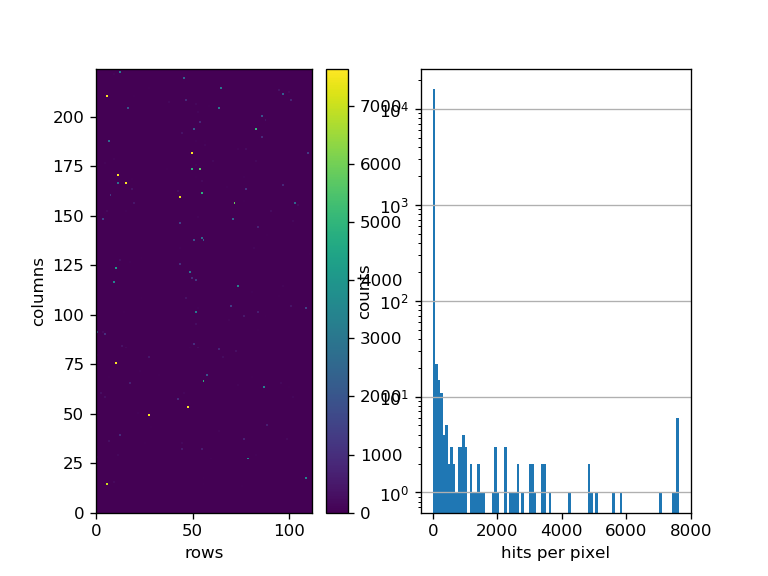

In [11]:
chip.unmask_all()
plots.tj_plot(chip);

Enable MASKH 50
Got 50735 hits, total noisy pixels: 35
Enable MASKH 100
Got 109379 hits, total noisy pixels: 88
Enable MASKH 150
Got 26767 hits, total noisy pixels: 133
Enable MASKH 200
Got 159870 hits, total noisy pixels: 198
Enable MASKH 223
Got 38082 hits, total noisy pixels: 219
Enable MASKV 50
Got 83 hits, total noisy pixels: 224
Enable MASKV 100
Got 123 hits, total noisy pixels: 227
Enable MASKV 111
Got 30 hits, total noisy pixels: 229
Enable MASKD 50
Got 83 hits, total noisy pixels: 231
Enable MASKD 100
Got 5 hits, total noisy pixels: 231
Enable MASKD 150
Got 91 hits, total noisy pixels: 231
Enable MASKD 200
Got 53 hits, total noisy pixels: 235
Enable MASKD 250
Got 20 hits, total noisy pixels: 240
Enable MASKD 300
Got 19 hits, total noisy pixels: 245
Enable MASKD 350
Got 131 hits, total noisy pixels: 248
Enable MASKD 400
Got 31 hits, total noisy pixels: 253
Enable MASKD 447
Got 78 hits, total noisy pixels: 255
Checking again after masking
Got 125 hits, total noisy pixels: 259
No

<IPython.core.display.Javascript object>


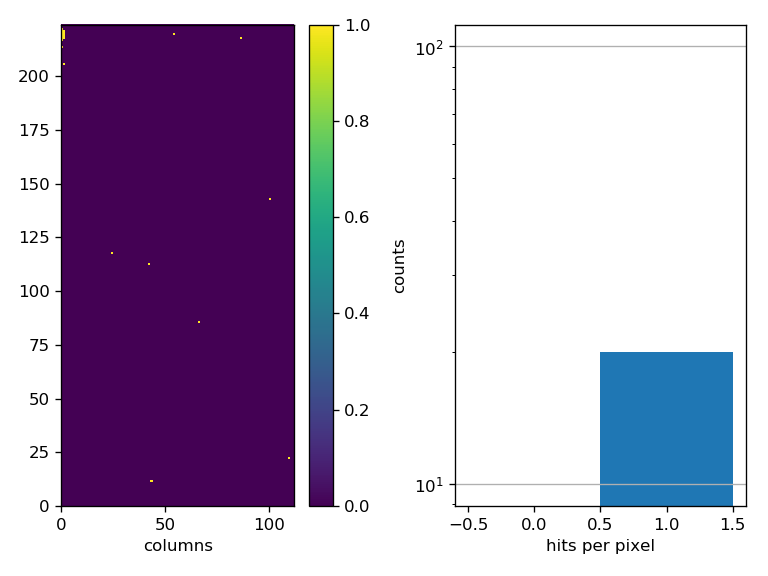

<IPython.core.display.Javascript object>


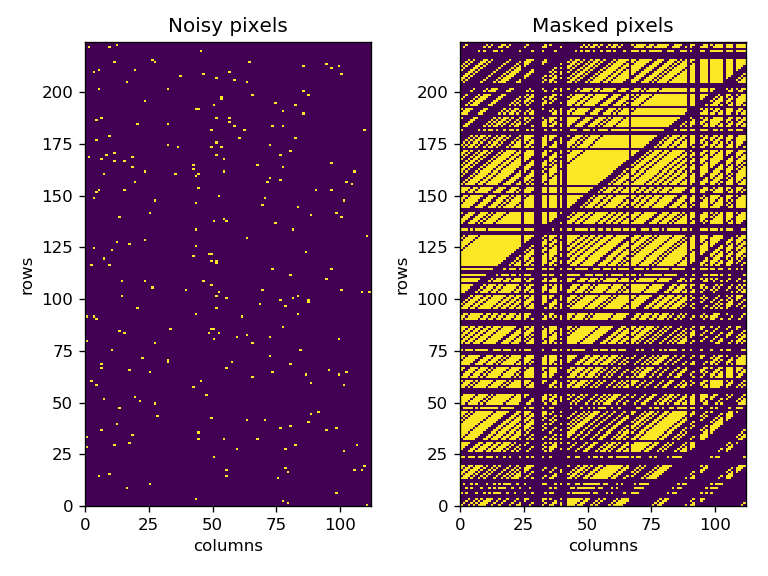

In [15]:
""" Software parameters to select: 
    the threshold above whitch a pixel is defined noisy (th = number of hits per pixel), 
    the step (),
    the time of the data acquisition run (in s) """
th = 2
step = 50
dt = 0.2

# Auto-mask and plot again
noisy_pixels, n_disabled_pixels, mask = chip.auto_mask(th=th, step=step, dt=dt)
plots.tj_plot(chip);

plt.figure()
plt.subplot(1, 2, 1)
plt.hist2d([x[1] for x in noisy_pixels], [x[2] for x in noisy_pixels], bins=[112,224], range=[[0,112],[0,224]])
plt.title("Noisy pixels")
plt.xlabel('columns')
plt.ylabel('rows')

plt.subplot(1, 2, 2)
plt.hist2d([x[0] for x in mask], [x[1] for x in mask], bins=[112,224], range=[[0,112],[0,224]])
plt.title("Masked pixels")
plt.xlabel('columns')
plt.ylabel('rows')

plt.tight_layout()
plt.show()

## OCCUPANCY

In [16]:
pix_tmp, cnt = chip.get_occupancy(dt);

Number of pixels counted: 19
column, row) hits 

(53, 179) 2
(52, 202) 2
(9, 149) 2
(2, 42) 2
(109, 22) 1
(102, 71) 1
(98, 142) 1
(87, 76) 1
(69, 53) 1
(51, 106) 1
(43, 11) 1
(22, 200) 1
(10, 109) 1
(8, 223) 1
(6, 182) 1


In [ ]:
#save some outout monitor files
date_string = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

output_file_power_status = date_string + 'power_status.txt'
output_file_parameters = 'parameters.txt'
output_file_noisy_pixels = date_string + '_noisy_pixels.txt'
output_file_hits_per_pixels = date_string + '_hits_pixels.txt'

noise_monitor.save_noisy_pixels(np.array(list(noisy_pixels)), output_file_noisy_pixels)
noise_monitor.save_param_and_noise(
    setted_param_dac, setted_param, len(noisy_pixels), n_disabled_pixels, output_file_parameters)
noise_monitor.save_power_status(power_status, output_file_power_status)

#noise_monitor.save_hits_per_pixels(hits, pixels, hits_per_pixel, output_file_hits_per_pixels)

# ENABLE INJECTION

Got 113 hits in 0.2 s


<IPython.core.display.Javascript object>


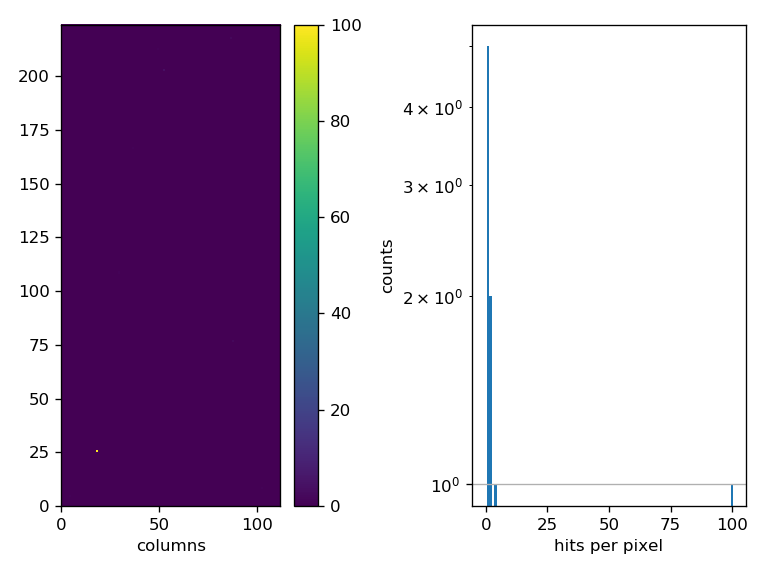

In [17]:
col_to_inject = 18
row_to_inject = 25

delay = 800 #in clock units (640 MHz)
width = 250
repeat = 100 #number of pulse injected
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
chip.enable_injection(3, col_to_inject, row_to_inject)
chip.write_conf()

_, pixels, hits_per_pixel = plots.tj_plot(chip, wait_inj=True)
chip['data_rx'].set_en(False)


## INJECTION SCANS -  S-CURVE

In [19]:
inj_low_dac = chip.get_vl_dacunits()
inj_low = vl
chip['data_rx'].set_en(True)
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
time.sleep(2)

#it is a signal from 40DAC (=vl) to 120DAC (=vh) and corresponds to a signal in 0.95-2.28V
#
injlist = np.arange(80, 0, -1)  
cnt = np.empty(len(injlist))
tot = np.empty(len(injlist))
inj_high = np.empty(len(injlist))

for inj_i, inj in enumerate(injlist):
    inj_high_dac = inj + inj_low_dac
    inj_high_pulse = chip.set_vh_dacunits(inj_high_dac, 0)
    chip.write_conf()
    for _ in range(5):
        chip['fifo'].reset()
        time.sleep(0.002)
    chip.set_monoread()
    chip["inj"].start()
    while not chip['inj'].is_ready:
        time.sleep(0.001)
    time.sleep(0.02)
    
    ix = chip.interpret_data(chip['fifo'].get_data())
    ix_inj = ix[np.bitwise_and(ix["col"] == col_to_inject, ix["row"] == row_to_inject)]
    cnt[inj_i] = len(ix_inj)
    tot[inj_i] = np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
    inj_high[inj_i] = inj_high_pulse
    print inj, inj_high_pulse, len(ix), len(ix_inj), tot[inj_i]
    

80 2.08578740157 101 100 43.87
79 2.07161417323 104 100 43.95
78 2.05744094488 105 100 43.89
77 2.04326771654 106 100 44.12
76 2.02909448819 103 100 43.97
75 2.01492125984 103 100 44.11
74 2.0007480315 105 100 43.97
73 1.98657480315 105 100 44.04
72 1.9724015748 106 100 44.22
71 1.95822834646 105 100 43.85
70 1.94405511811 104 100 44.19
69 1.92988188976 106 100 43.96
68 1.91570866142 104 100 43.83
67 1.90153543307 102 100 43.25
66 1.88736220472 106 100 43.36
65 1.87318897638 104 100 43.16
64 1.85901574803 107 100 42.57
63 1.84484251969 108 100 42.44
62 1.83066929134 104 100 42.07
61 1.81649606299 109 100 41.39
60 1.80232283465 104 100 40.85
59 1.7881496063 103 100 40.22
58 1.77397637795 103 100 39.62
57 1.75980314961 105 100 38.75
56 1.74562992126 105 100 37.9
55 1.73145669291 102 100 36.98
54 1.71728346457 105 100 36.21
53 1.70311023622 102 100 35.69
52 1.68893700787 103 100 34.79
51 1.67476377953 103 100 33.73
50 1.66059055118 102 100 32.72
49 1.64641732283 105 100 31.41
48 1.6322440

C:\ProgramData\Miniconda2\lib\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\ProgramData\Miniconda2\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


15 1.16452755906 5 0 nan
14 1.15035433071 6 0 nan
13 1.13618110236 7 0 nan
12 1.12200787402 6 0 nan
11 1.10783464567 12 0 nan
10 1.09366141732 3 0 nan
9 1.07948818898 8 0 nan
8 1.06531496063 5 0 nan
7 1.05114173228 5 0 nan
6 1.03696850394 6 0 nan
5 1.02279527559 8 0 nan
4 1.00862204724 8 0 nan
3 0.994448818898 1 0 nan
2 0.980275590551 5 0 nan
1 0.966102362205 1 0 nan


approx. th = 21 DAC = 1.538 V = 693 e-
sigma 7 DAC = 0.513 V = 231 e-


<IPython.core.display.Javascript object>


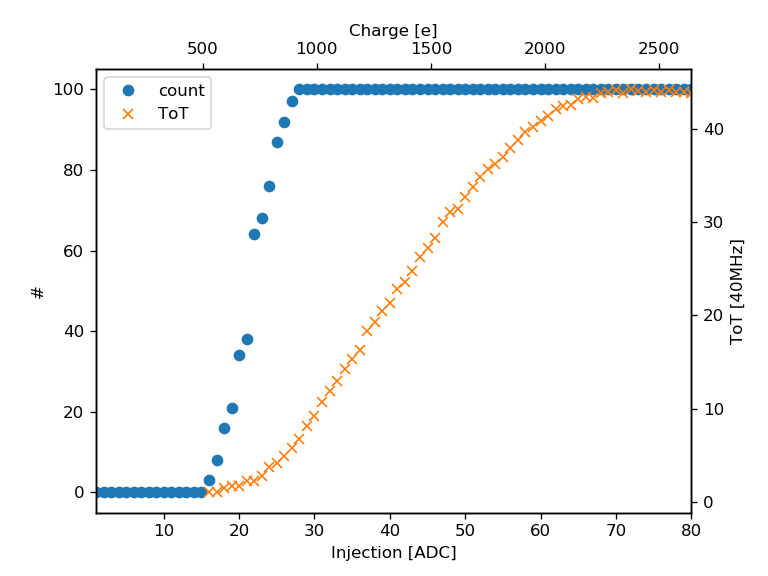

In [32]:
conversion_factor = np.mean(inj_high/injlist)
    
approx_threshold_dac = injlist[np.argmin( np.abs(cnt - repeat/2) )]
approx_threshold = approx_threshold_dac * conversion_factor
charge_threshold = approx_threshold_dac * CALCAP
print "approx. th = %d DAC = %.3f V = %g e-" % (approx_threshold_dac, approx_threshold, charge_threshold)

sigma_dac = injlist[np.argmin( np.abs(cnt - repeat * 0.84) )] - injlist[np.argmin( np.abs(cnt - repeat * 0.16) )]
print "sigma %d DAC = %.3f V = %g e-" % (sigma_dac, sigma_dac * conversion_factor, sigma_dac * CALCAP)  

fig,ax = plt.subplots(1,1)
ax.plot(injlist, cnt, "C0o", label="count")
ax2 = ax.twiny()
ax3 = ax.twinx()
ax3.plot(injlist,tot,"C1x",label="ToT")
ax.plot([],[],"C1x",label="ToT")

ax.set_xlabel("Injection [ADC]")
ax.set_ylabel("#")
ax3.set_ylabel("ToT [40MHz]")
ax2.set_xlabel("Charge [e]")
ax.set_xbound(np.min(injlist), np.max(injlist))
ax2.set_xbound(np.min(injlist) * CALCAP, np.max(injlist) * CALCAP)
ax.legend()